<a href="https://colab.research.google.com/github/marinebon/HackingLimno2025/blob/main/02_searchERDDAP4data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use `erddapy` to query multiple data servers for data of interest

In this notebook we use the package [erddapy](https://ioos.github.io/erddapy/03-advanced_search-output.html) to query for environmental data in a spitaltemporal region that aligns with our species occurrence data.

In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["netCDF4", "xarray", "erddapy"]
_colab_install_missing_deps(deps)

Install netCDF4? [y/n]:y
netCDF4 installed!
Install erddapy? [y/n]:y
erddapy installed!


## Read occurrence data from previous notebook

In [5]:
import pandas as pd

In [6]:
df = pd.read_parquet('occurrences.parquet')

df.head()

,decimalLatitude,decimalLongitude,occurrenceStatus,year,date_mid
0,-32.095973,115.700258,present,None,9.308736e+11
1,-32.076297,115.744402,present,None,9.308736e+11
2,-32.133319,115.729781,present,None,9.308736e+11
3,-34.057323,151.136528,present,None,1.183334e+12
4,43.340100,5.262466,present,2007,1.176336e+12


In [15]:
from erddapy.multiple_server_search import advanced_search_servers

min_time = df['year'].dropna().min()#"2000-01-01T00:00:00Z"
max_time = df['year'].dropna().max()#"2024-12-31T00:00:00Z"
min_lon, max_lon = df['decimalLongitude'].dropna().min(), df['decimalLongitude'].dropna().max()
min_lat, max_lat = df['decimalLatitude'].dropna().min(), df['decimalLatitude'].dropna().max()
standard_name = "sea_water_temperature"

# From 01-OBIS query:
# min time = 2000-01-01 max time = 2024-12-31
# Lat min =-46.906670	lon min =-177.367000
# lat max = 65.797040	lon max = 179.660400

kw = {
    "standard_name": standard_name,
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_time": min_time,
    "max_time": max_time,
    "cdm_data_type": "timeseries",
}

df = advanced_search_servers(
    servers_list=None,
    parallel=True,
    protocol="tabledap",
    **kw
)

df.sample(n=5)

,Title,Institution,Dataset ID,Server url
2001,Morro Bay (Back Bay),"California Polytechnic State University, Cente...",morro-bay-bs1,https://erddap.sensors.ioos.us/erddap/
1695,JWS Padaro Offshore J,California State University Long Beach,jws-padaro-offshore-j,https://erddap.sensors.ioos.us/erddap/
5674,USGS-CMG time-series data: MVCO_11 - 910 - 910...,USGS Coastal and Marine Geology Program,9105advs-cal,https://geoport.usgs.esipfed.org/erddap/
6141,TimeSeries - Y1.x014.000.0003 - 20110127_20110...,Dauphin Island Sea Lab,Y1_x014_000_0003_20110127_20110414_alltemp,https://erddap.griidc.org/erddap/
639,"230 - Isle Royale East, MI (45180)",Coastal Data Information Program (CDIP),edu_ucsd_cdip_230,https://erddap.sensors.ioos.us/erddap/


Once you have identified datasets of interest, download the relevant data into /data/.

How many servers matched our query?

In [16]:
df['Server url'].unique()

array(['https://erddap.observations.voiceoftheocean.org/erddap/',
       'https://erddap.ogsl.ca/erddap/',
       'https://coastwatch.pfeg.noaa.gov/erddap/',
       'https://erddap.emodnet-physics.eu/erddap/',
       'https://erddap.sensors.ioos.us/erddap/',
       'http://erddap.cencoos.org/erddap/',
       'http://www.neracoos.org/erddap/',
       'https://pae-paha.pacioos.hawaii.edu/erddap/',
       'http://erddap.secoora.org/erddap/',
       'http://osmc.noaa.gov/erddap/', 'http://dap.onc.uvic.ca/erddap/',
       'https://erddap.dataexplorer.oceanobservatories.org/erddap/',
       'https://salishsea.eos.ubc.ca/erddap/',
       'http://bmlsc.ucdavis.edu:8080/erddap/',
       'https://upwell.pfeg.noaa.gov/erddap/',
       'https://ferret.pmel.noaa.gov/pmel/erddap/',
       'https://catalogue.hakai.org/erddap/',
       'https://geoport.usgs.esipfed.org/erddap/',
       'https://www.smartatlantic.ca/erddap/',
       'https://erddap.griidc.org/erddap/',
       'https://cioosatlantic.ca/

How many unique datasets did we find?

In [17]:
len(df['Dataset ID'].unique())

4908

How many total datasets did we find?

In [18]:
df.shape

(6182, 4)

Let's build the ERDDAP url for one of the cencoos datasets

In [47]:
ra = 'sensors'

df_ra = df.loc[df['Server url'].str.contains(ra)].reset_index(drop=True)

dataset_id = df_ra.iloc[900]['Dataset ID']

server = df_ra['Server url'].unique()[0]

print(f"{server}{dataset_id}")

https://erddap.sensors.ioos.us/erddap/org_secoora_fscapea_yaps_12


In [44]:
df_ra

,Title,Institution,Dataset ID,Server url
0,"(41024 / SUN2) Sunset Nearshore Met and Water, NC",UNCW - Coastal Ocean Research and Monitoring P...,ism-secoora-org_cormp_sun2,https://erddap.sensors.ioos.us/erddap/
1,"(41024 / SUN2) Sunset Nearshore Met and Water, NC",UNCW - Coastal Ocean Research and Monitoring P...,org_cormp_sun2,https://erddap.sensors.ioos.us/erddap/
2,"(41029 / CAP2) Capers Nearshore, SC",UNCW - Coastal Ocean Research and Monitoring P...,ism-secoora-org_cormp_cap2,https://erddap.sensors.ioos.us/erddap/
3,"(41029 / CAP2) Capers Nearshore, SC",UNCW - Coastal Ocean Research and Monitoring P...,org_cormp_cap2,https://erddap.sensors.ioos.us/erddap/
4,"(41033 / FRP2) Fripp Nearshore, NC",UNCW - Coastal Ocean Research and Monitoring P...,ism-secoora-org_cormp_frp2,https://erddap.sensors.ioos.us/erddap/
...,...,...,...,...
2410,"YATA2 - 9453220- Yakutat, AK",NOAA Center for Operational Oceanographic Prod...,ism-aoos-noaa_nos_co_ops_yata2,https://erddap.sensors.ioos.us/erddap/
2411,Yentna R Nr Susitna Station Ak (Imiq: 15708),USGS National Water Information System (NWIS),imiq_15708_nwis-15294345,https://erddap.sensors.ioos.us/erddap/
2412,"Yorktown USCG Training Center, VA (YKTV2)",NOAA Center for Operational Oceanographic Prod...,noaa_nos_co_ops_8637689,https://erddap.sensors.ioos.us/erddap/
2413,YUKON R AT PILOT STATION AK,USGS National Water Information System (NWIS),ism-aoos-gov_usgs_waterdata_1556-1,https://erddap.sensors.ioos.us/erddap/


Let's use erddapy to query for one specific dataset and return the data.

In [48]:
from erddapy import ERDDAP

e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

e.dataset_id = dataset_id

df_data = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
)

df_data.sample(n=5)

,latitude (degrees_north),longitude (degrees_east),z (m),sea_water_temperature (degree_Celsius),sea_water_temperature_qc_agg,sea_water_temperature_qc_tests,station
time (UTC),,,,,,,
2022-10-15 00:00:00+00:00,24.991,-80.4268,-26.0,28.374,1,22212111222,NaN
2022-07-18 10:00:00+00:00,24.991,-80.4268,-26.0,29.605,1,22212111222,NaN
2022-08-02 04:00:00+00:00,24.991,-80.4268,-26.0,29.577,1,22212111222,NaN
2022-11-27 13:00:00+00:00,24.991,-80.4268,-26.0,26.864,1,22212111222,NaN
2022-08-10 19:00:00+00:00,24.991,-80.4268,-26.0,29.549,1,22212111222,NaN


Let's make a T-S diagram. Making dots colored for pco2 data.

<Axes: xlabel='Salinity (psu)', ylabel='Temperature (celsius)'>

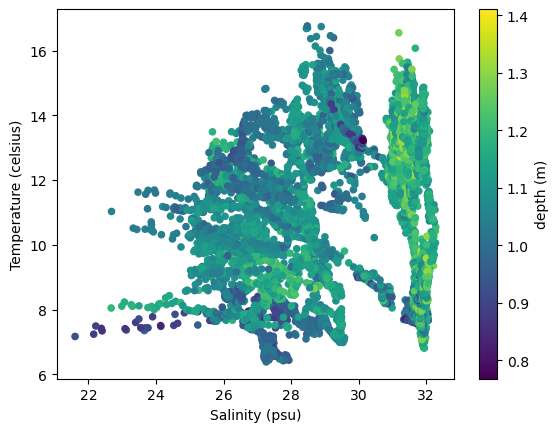

In [ ]:
df_data.plot.scatter(x='Salinity (psu)',y='sea_water_temperature (degree_Celsius)',c='depth (m)')

Where is this station located?

In [42]:
import plotly.express as px
import pandas as pd


# Create a scatter plot on a map
fig = px.scatter_geo(
    df_data,
    lat='latitude (degrees_north)',
    lon='longitude (degrees_east)',
    hover_name='station',
    projection='natural earth',
    title='Station on a Map',
    scope='north america',
)
fig.show()